# Necessary Libraries

In [120]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer, MissingIndicator
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
from fancyimpute import SoftImpute
import ace_tools_open as tools 
import time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Step 2: Imputation with Multiple ML Methods
4 different methods are used to fill the gaps: 
1. Mean/Median/Mode Imputation (Baseline)
2. KNN Imputer
3. Iterative Imputer (similar to MICE)
4. Matrix Factorization (MF)


In [ ]:

# Load dataset
df = pd.read_csv('C://Users/.../.csv')
numeric_df = df.select_dtypes(include=[np.number])

# Train-test split
X_train, X_test = train_test_split(numeric_df, test_size=0.2, random_state=42)
original = X_test.copy()
X_test_missing = X_test.mask(np.random.rand(*X_test.shape) < 0.2)

# Timer dictionary
Timer = {}
imputation_methods = {
    'Mean': SimpleImputer(strategy='mean'),
    'Median': SimpleImputer(strategy='median'),
    'KNN': KNNImputer(n_neighbors=5),
    'Iterative_RF': IterativeImputer(random_state=0, estimator=None, max_iter=10),
    'MatrixFactorization': SoftImpute()
}
imputed_results = {}
for name, imputer in imputation_methods.items():
    start = time.time()
    if name == 'MatrixFactorization':
        imputed = imputer.fit_transform(X_test_missing)
    else:
        imputer.fit(X_train)
        imputed = imputer.transform(X_test_missing)
    end = time.time()
    Timer[name] = end - start
    imputed_results[name] = imputed
    print(f"{name} imputation done. Runtime: {Timer[name]:.4f} s, Remaining NaNs: {np.isnan(imputed).sum()}")
    

Mean imputation done. Runtime: 0.0114 s, Remaining NaNs: 0
Median imputation done. Runtime: 0.0312 s, Remaining NaNs: 0
KNN imputation done. Runtime: 5.9996 s, Remaining NaNs: 0
Iterative_RF imputation done. Runtime: 18.9952 s, Remaining NaNs: 0
[SoftImpute] Max Singular Value of X_init = 3109487.826865
[SoftImpute] Iter 1: observed MAE=97.278754 rank=3
[SoftImpute] Iter 2: observed MAE=92.112265 rank=3
[SoftImpute] Iter 3: observed MAE=92.217300 rank=3
[SoftImpute] Iter 4: observed MAE=92.698096 rank=3
[SoftImpute] Iter 5: observed MAE=92.983049 rank=3
[SoftImpute] Iter 6: observed MAE=93.127757 rank=3
[SoftImpute] Iter 7: observed MAE=93.200457 rank=3
[SoftImpute] Iter 8: observed MAE=93.237838 rank=3
[SoftImpute] Iter 9: observed MAE=93.259081 rank=3
[SoftImpute] Iter 10: observed MAE=93.272133 rank=3
[SoftImpute] Iter 11: observed MAE=93.281321 rank=3
[SoftImpute] Iter 12: observed MAE=93.288515 rank=3
[SoftImpute] Iter 13: observed MAE=93.294787 rank=3
[SoftImpute] Iter 14: observ

# Step 3: Evaluate Imputation Quality

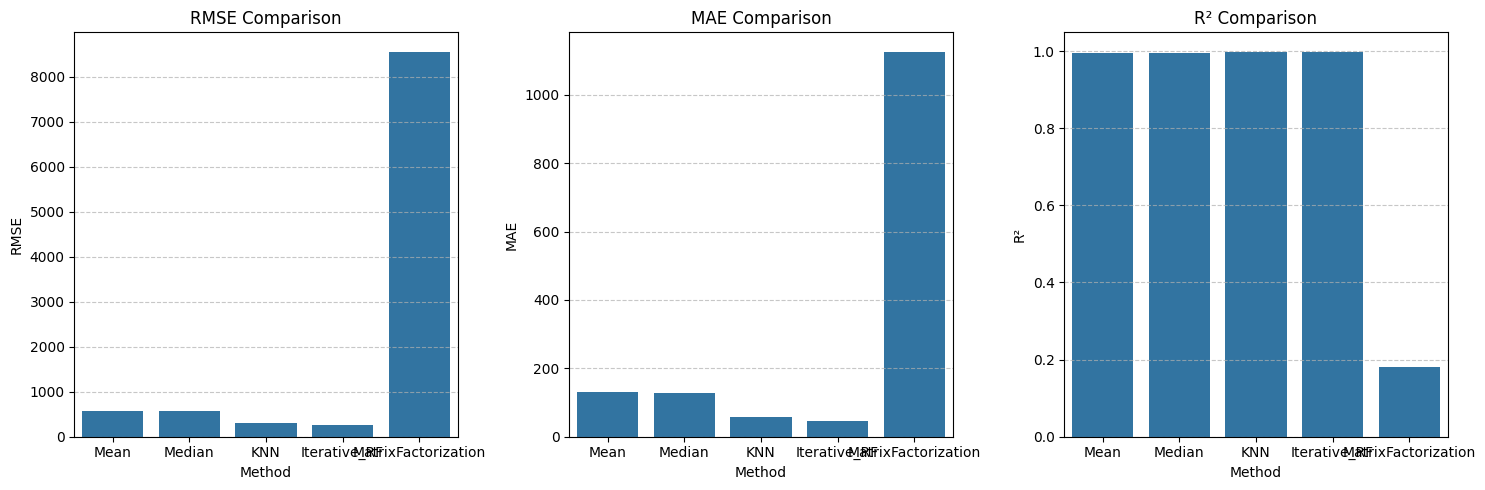

In [131]:
def evaluate_imputation(original, imputed, mask):
    original, imputed = original[mask], imputed[mask]
    valid = ~np.isnan(original) & ~np.isnan(imputed)
    if valid.sum() == 0:
        return np.nan, np.nan, np.nan
    rmse = np.sqrt(mean_squared_error(original[valid], imputed[valid]))
    mae = mean_absolute_error(original[valid], imputed[valid])
    r2 = r2_score(original[valid], imputed[valid])
    return rmse, mae, r2
mask = X_test_missing.isna().to_numpy()

metrics = {}
for name, imputed in imputed_results.items():
    rmse, mae, r2 = evaluate_imputation(original.to_numpy(), imputed, mask)
    metrics[name] = {'RMSE': rmse, 'MAE': mae, 'R²': r2}
metrics_df = pd.DataFrame(metrics).T

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.barplot(x=metrics_df.index, y='RMSE', data=metrics_df, ax=axes[0])
axes[0].set_title('RMSE Comparison')
sns.barplot(x=metrics_df.index, y='MAE', data=metrics_df, ax=axes[1])
axes[1].set_title('MAE Comparison')
sns.barplot(x=metrics_df.index, y='R²', data=metrics_df, ax=axes[2])
axes[2].set_title('R² Comparison')

for ax in axes:
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.set_xlabel('Method')
plt.tight_layout()
plt.show()

# Step 4: Visualization of Results
How good each model performs on fitting on data

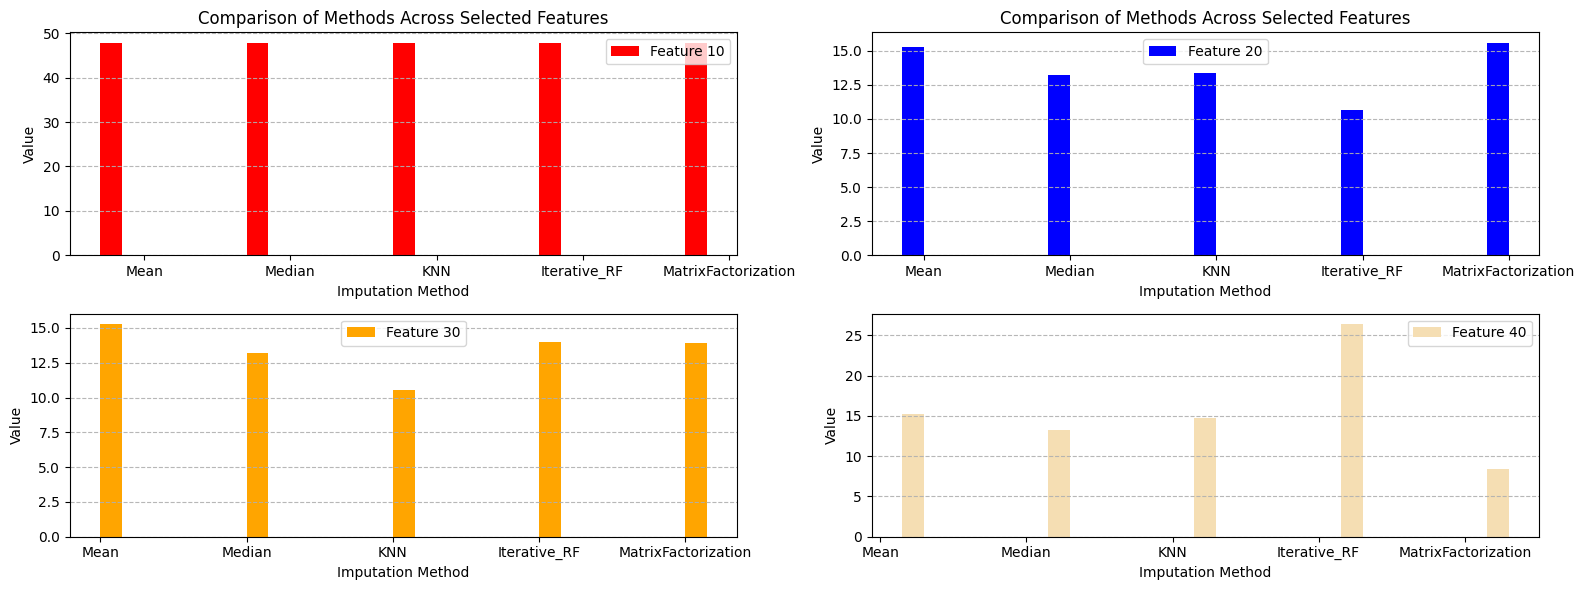

In [146]:
colors = ['red', 'blue', 'orange', 'wheat']
ffeatures = [10, 20, 30, 40]
methods = list(imputed_results.keys())
num_methods = len(methods)
f, ax = plt.subplots(2, 2, figsize=(16, 6))
width = 0.15
for j, feature_idx in enumerate(ffeatures):
    feature_values = [imputed_results[m][feature_idx][6] for m in methods]
    positions = np.arange(num_methods) + j * width
    ax[j//2, j%2].bar(positions, feature_values, width=width, label=f'Feature {feature_idx}', color = colors[j])
    ax[j//2, j%2].set_xticks(np.arange(num_methods) + width*(len(ffeatures)-1)/2, methods)
    ax[j//2, j%2].set_xlabel("Imputation Method")
    ax[j//2, j%2].set_ylabel("Value")
    ax[j//4, j%2].set_title("Comparison of Methods Across Selected Features")
    ax[j//2, j%2].legend()
    ax[j//2, j%2].grid(axis='y', linestyle='--', alpha=0.9)
plt.tight_layout()
plt.show()


In [148]:

results = {}
for name, imputer in imputation_methods.items():
    start_time = time.time()
    if name == 'MatrixFactorization':
        imputed_data = imputer.fit_transform(X_test_missing)
    else:
        imputer.fit(X_train)
        imputed_data = imputer.transform(X_test_missing)
    duration = time.time() - start_time
    results[name] = imputed_data

    mask = X_test_missing.isna().to_numpy()
    valid = ~np.isnan(original.to_numpy()) & mask
    y_true = original.to_numpy()[valid]
    y_pred = imputed_data[valid]
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    metrics[name] = {'RMSE': rmse, 'MAE': mae, 'R2': r2, 'Time (s)': duration}
metrics_df = pd.DataFrame(metrics).T


[SoftImpute] Max Singular Value of X_init = 3109487.826865
[SoftImpute] Iter 1: observed MAE=97.278754 rank=3
[SoftImpute] Iter 2: observed MAE=92.112265 rank=3
[SoftImpute] Iter 3: observed MAE=92.217300 rank=3
[SoftImpute] Iter 4: observed MAE=92.698096 rank=3
[SoftImpute] Iter 5: observed MAE=92.983049 rank=3
[SoftImpute] Iter 6: observed MAE=93.127757 rank=3
[SoftImpute] Iter 7: observed MAE=93.200457 rank=3
[SoftImpute] Iter 8: observed MAE=93.237838 rank=3
[SoftImpute] Iter 9: observed MAE=93.259081 rank=3
[SoftImpute] Iter 10: observed MAE=93.272133 rank=3
[SoftImpute] Iter 11: observed MAE=93.281321 rank=3
[SoftImpute] Iter 12: observed MAE=93.288515 rank=3
[SoftImpute] Iter 13: observed MAE=93.294787 rank=3
[SoftImpute] Iter 14: observed MAE=93.300511 rank=3
[SoftImpute] Iter 15: observed MAE=93.305879 rank=3
[SoftImpute] Iter 16: observed MAE=93.311056 rank=3
[SoftImpute] Iter 17: observed MAE=93.316046 rank=3
[SoftImpute] Iter 18: observed MAE=93.320886 rank=3
[SoftImpute] I

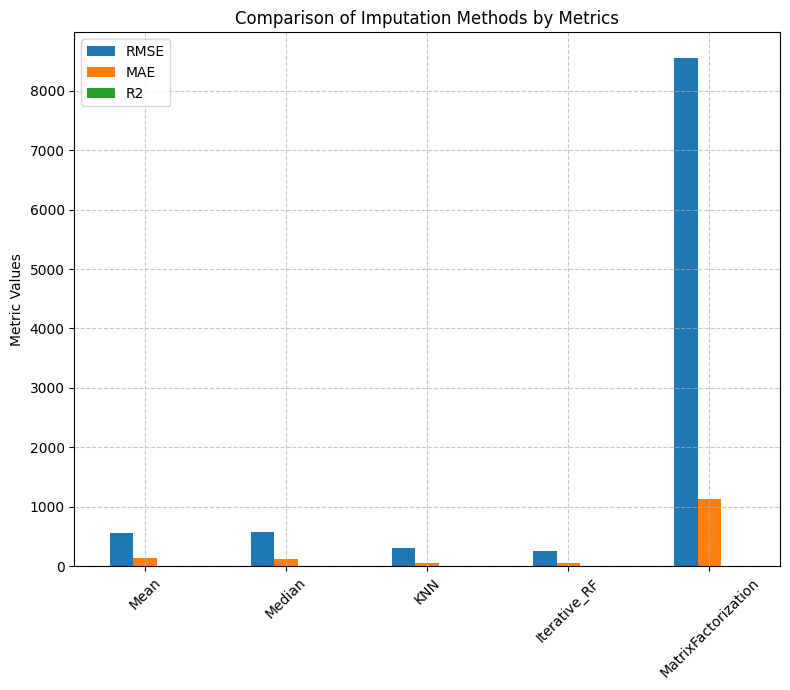

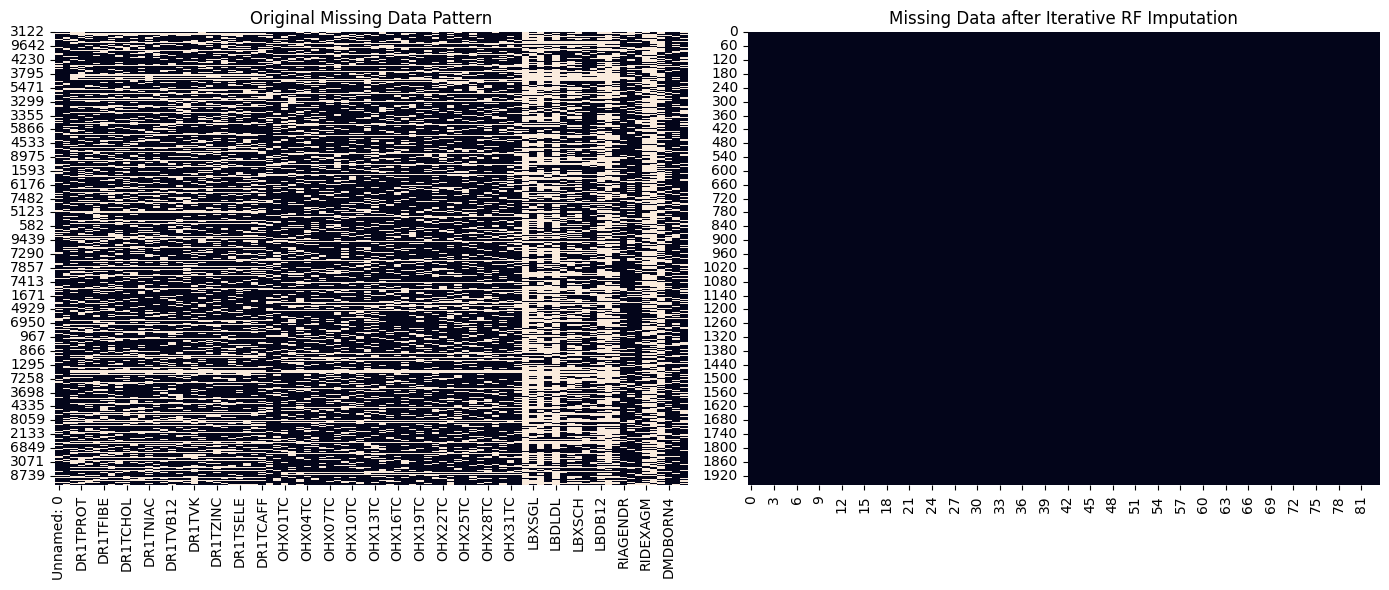

Imputation Methods Metrics


,RMSE,MAE,R2,Time (s)
Mean,565.096966,129.070972,0.996419,0.020477
Median,568.975719,127.999518,0.996370,0.033276
KNN,300.991245,56.525470,0.998984,5.849359
Iterative_RF,257.252470,44.873359,0.999258,18.958640
MatrixFactorization,8554.683027,1126.989982,0.179306,2.200991


In [149]:
fig, ax = plt.subplots(figsize=(8, 7))
metrics_df[['RMSE', 'MAE', 'R2']].plot(kind='bar', ax=ax)
plt.title('Comparison of Imputation Methods by Metrics')
plt.ylabel('Metric Values')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.heatmap(X_test_missing.isna(), cbar=False, ax=axes[0])
axes[0].set_title('Original Missing Data Pattern')
sns.heatmap(pd.DataFrame(results['Iterative_RF']).isna(), cbar=False, ax=axes[1])
axes[1].set_title('Missing Data after Iterative RF Imputation')
plt.tight_layout()
plt.show()

tools.display_dataframe_to_user(name="Imputation Methods Metrics", dataframe=metrics_df)
metrics_df